# Benchmarks

This notebook will calculate benchmarks/baselines used in the project thesis. 

The following benchmarks are developed in this notebook: 
1. Simple heuristics
    - Predict the previous value
    - Predict the mean of the training data
    - Predict the moving average of the sequence
2. Linear regression
    - Linear regression using least squares minimisation
    - Ridge regression
    - LASSO
    - Elastic Nets (ElNet)
3. Simpler Machine Learning
    - Random Forest (RF)
    - Gradient Boosting Machines (GBM)

In [1]:
%reset -f

Import the necessary packages.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rc
from datetime import datetime
from tabulate import tabulate
from decimal import Decimal

from functions import MAE, RMSE

In [2]:
# Set global paths
ROOT_PATH = os.path.abspath(".").split("main")[0]

# configure matplotlib params and plotting
## use seaborn as this gives nicer plots than the standard 
sns.set()
sns.set_context('paper')
sns.set_style('whitegrid', {'axes.grid': True, 'grid.linestyle': '--'})

rc('figure', figsize=(12,6))
rc('xtick', labelsize=12)
rc('ytick', labelsize=12)
rc('axes', labelsize=13, titlesize=14)
rc('legend', fontsize=14, handlelength=2)

## (1) Read the data from files
---

In [3]:
# read data
df2np = np.load(ROOT_PATH + "data/standardized/standardized_complete.npy")
df2np_train = np.load(ROOT_PATH + "data/standardized/standardized_train.npy")
df2np_valid = np.load(ROOT_PATH + "data/standardized/standardized_valid.npy")
df2np_test = np.load(ROOT_PATH + "data/standardized/standardized_test.npy")

T_train = np.load(ROOT_PATH + "data/metadata/timevec_train.npy")
T_valid = np.load(ROOT_PATH + "data/metadata/timevec_valid.npy")
T_test = np.load(ROOT_PATH + "data/metadata/timevec_test.npy")

use_dummy_data = False
if use_dummy_data:
    num_obs = 6000  # 6000, 20000 or 50000
    df2np = np.load(ROOT_PATH + "data/dummy_data/dummy_complete_{}.npy".format(num_obs))
    df2np_train = np.load(ROOT_PATH + "data/dummy_data/dummy_train_{}.npy".format(num_obs))
    df2np_valid = np.load(ROOT_PATH + "data/dummy_data/dummy_valid_{}.npy".format(num_obs))
    df2np_test = np.load(ROOT_PATH + "data/dummy_data/dummy_test_{}.npy".format(num_obs))

train_size = df2np_train.shape[0]
valid_size = df2np_valid.shape[0]
test_size = df2np_test.shape[0]
print(train_size, valid_size, test_size)

# read metadata
feature_tags = list(np.load(ROOT_PATH + "data/metadata/feature_tags.npy"))
target_tags = list(np.load(ROOT_PATH + "data/metadata/target_tags.npy"))
headers = feature_tags + target_tags

means = np.load(ROOT_PATH + "data/metadata/means.npy")
stds = np.load(ROOT_PATH + "data/metadata/stds.npy")

50635 16878 16879


### Split data in subsets of inputs/targets and introduce delay
The training, validation and testing sets are divided into subsets of their respective inputs and outputs. The targets are lagged by `delay`=1. As a result, the number of observations in the training, validation and testing sets are reduced by the value of `delay`. 

In [4]:
delay = 1  # targets will be 1 timesteps in the future, i.e. the next 30-second value.

# divide into training, validation and testing sets
inputs_idxs = np.array(range(len(feature_tags)))
outputs_idxs = np.array(range(len(feature_tags), len(headers)))

x_train = df2np_train[:-delay,inputs_idxs]
y_train = df2np_train[delay:,outputs_idxs]

x_valid = df2np_valid[:-delay,inputs_idxs]
y_valid = df2np_valid[delay:,outputs_idxs]

x_test = df2np_test[:-delay,inputs_idxs]
y_test = df2np_test[delay:,outputs_idxs]

## Defining "global" functions for evaluation
The following functions are used to evaluate the heuristics and linear models.

In [5]:
def evaluate_error(preds, targets, target_stdevs=stds[len(feature_tags):]):
    """
    Will evaluate the MAE of a set of predictions and targets.
    
    :param preds: Matrix of predictions with shape (n_obs, n_target_variables)
    :param targets: Matrix of true targets with shape (n_obs, n_target_variables)
    :param target_stdevs: 1D vector of the standard deviations of the target variables.
    
    :return return_dict: A dictionary with the computed error variables. 
    """
    
    maes = MAE(targets, preds, vector=True)
    maes_unstd = (maes * target_stdevs)
    avg_mae = np.mean(maes)
    avg_mae_unstd = np.mean(maes_unstd)

    err_df = pd.DataFrame(np.column_stack([target_tags, maes, maes_unstd]), 
                          columns=['Tag', 'MAE (Standardized)', 'MAE (Unstandardized)'])
    err_df.loc[len(err_df)] = ["Average", avg_mae, avg_mae_unstd]
    str_table = tabulate(err_df, headers='keys', tablefmt='psql', floatfmt='.5f')

    return_dict = {
        'err_df': err_df,
        'err_table': str_table,
        'maes': maes,
        'maes_unstd': maes_unstd,
        'avg_mae': avg_mae,
        'avg_mae_unstd': avg_mae_unstd
    }
    
    return return_dict

In [6]:
%%capture
def format_digit(digit, n_digits=5):
    """
    Rounds a digit to n_digit significant numbers. Large numbers are returned in scientific notation (e.g. 4.3E+4)
    
    :param digit: The digit as float
    :param n_digits: The number of digits to round to. Default=4. 
    :return: The formatted digit
    """
    
    len_digit = len(str(digit).split(".")[0])
    if len_digit > 3:
        string = '%.2E' % Decimal(str(digit))
        splt = string.split("+")
        string = splt[0] + "+" + splt[1][1]
        return string
    
    round_int = max(1, n_digits-len_digit)
    stripped = round(digit,round_int)
    return str(stripped)

In [34]:
# helper function to latexify a dataframe
def latexify(df):
    multirow = type(df.index) == pd.core.indexes.multi.MultiIndex
    multicolumn = type(df.columns) == pd.core.indexes.multi.MultiIndex
    
    col_format = "ll" if multirow else "l"
    col_format += "c"*len(df.columns.levels[1])*2 if multicolumn else "c"*len(df.columns)
    
    tex = df.to_latex(column_format=col_format,
                      multicolumn=multicolumn, 
                      multicolumn_format='c',
                      multirow=multirow,
                      bold_rows=True)
    
    return tex

In [35]:
def get_summary(val_dicts, test_dicts, columns, indexes, unstd=False, texpath=None, round_digits=4):
    """
    Method that concatenates validation and test dictionaries (as obtained by evaluate_error()) into a dataframe.
    Is typically used to get a summary of multiple methods and their performance on test and validation data. 
    
    :param val_dicts: Validation dictionaries as obtained by evalueate_error()
    :param test_dicts: Test dictionaries as obtained by evaluate_error()
    :param columns: Vector of column names for the dataframe
    :param indexes: Vector of index names for the dataframe
    :param unstd: Boolean if the MAEs should be unstandardized or not. Default=False. 
    :param texpath: Path to save the obtained latex output. Default=None. 
    :round_digit: The significant digits to round a decimal to, used in format_digit(). Default=4. 
    
    :return: The summary dataframe and the latex string of the dataframe. 
    """
    
    name = 'maes_unstd' if unstd else 'maes'
    val_data = []
    for i, d in enumerate(val_dicts):
        tmp = np.append(d[name], d['avg_mae'])
        tmp = [format_digit(digit) for digit in tmp]
        val_data.append(tmp)

    test_data = []
    for i, d in enumerate(test_dicts):
        tmp = np.append(d[name], d['avg_mae'])
        tmp = [format_digit(digit) for digit in tmp]
        test_data.append(tmp)

    val_df = pd.DataFrame(np.vstack(val_data), index = indexes, columns=columns)
    test_df = pd.DataFrame(np.vstack(test_data), index = indexes, columns=columns)
    summary_df = pd.concat([val_df, test_df], axis=1, keys=["Validation", "Test"])
    
    tex = latexify(summary_df)

    if texpath is not None: # save the file
        with open(texpath, 'w+') as f:
            f.write(tex)
    
    return summary_df, tex

## Verifying the correctness of the standardized and unstandardized MAE
Is it the same to multiply the MAE by the std as manually unstandardizing the inputs and calculating the MAE?

In [36]:
# calculate the unstandardized MAE with evaluate_error
preds = y_valid[:-1,:]
targets = y_valid[:1,:]
err_dict = evaluate_error(preds,targets)
print(err_dict['maes_unstd'])

# manually unscale the data and check correspondence
y_valid_unstd = np.copy(y_valid)
y_valid_unstd *= stds[len(feature_tags):]
y_valid_unstd += means[len(feature_tags):]

preds = y_valid_unstd[:-1,:]
targets = y_valid_unstd[:1,:]

maes_unstd = MAE(targets,preds, vector=True)
print(maes_unstd)

[2.10186747e+04 7.85667660e+00 6.47885353e-01]
[2.10186747e+04 7.85667660e+00 6.47885353e-01]


We see that they are the same, so we'll confidently use MAE x STD from now on to calculate the unstandardised error.

# (2) Implementation of simple heuristics
---

### Defining functions for evaluating and visualising the heuristics

In [37]:
def evaluate_heuristic(func):
    """
    Evaluates a heuristic by printing results for the validation and testing data.
    
    :param func: A function representing the heuristic that returns predictions and targets.
    :return val_errs, test_errs: The dictionaries obtained by the evaluate_error()-function. 
    """
    
    print("\n       Validation data")
    preds, targets = func(y_valid)
    val_errs = evaluate_error(preds,targets)
    print(val_errs['err_table'])

    print("\n       Testing data")
    preds, targets = func(y_test)
    test_errs = evaluate_error(preds,targets)
    print(test_errs['err_table'])
    
    return val_errs, test_errs

In [38]:
def visualise_heuristic(func, y_data=y_valid, n_obs=100, signal=1):
    """
    Visualises the heuristic with a sample plot. 
    
    :param func: A function representing the heuristic that returns predictions and targets.
    :param y_data: The data with the true targets. Default set to y_valid. 
    :param n_obs: The number of observations that will be plotted. Default set to 100. 
    :param signal: The target that will be plotted. Default set to 1, i.e. the temperature. 
    """
    
    preds, targets = func(y_data)
    preds = preds[:,signal] if np.array(preds).shape==targets.shape else np.repeat(preds[signal],len(y_data))
    targets = targets[:,signal]

    plt.figure()
    plt.plot(preds[:n_obs], linestyle="dashed", lw=2, c="darkblue", label="Predicted")
    plt.plot(targets[:n_obs], c="darkred", lw=2, label="True")
    plt.legend(frameon=True)
    plt.ylabel(target_tags[signal])
    plt.show()

### Predict the the previous value
Now setting $y(t+1) = y(t)$. Visualising this with a plot:

In [39]:
def predict_previous(y_data):
    preds = y_data[:-1,:]
    targets = y_data[1:,:]
    
    return preds, targets

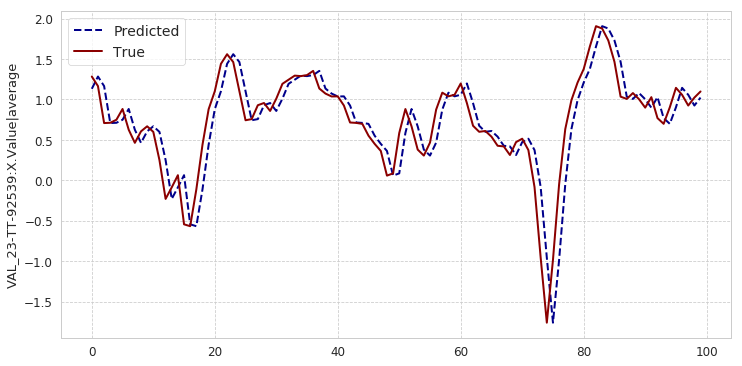

In [40]:
visualise_heuristic(predict_previous)

In [41]:
print("\nPREDICTING PREVIOUS")
val_prev, test_prev = evaluate_heuristic(predict_previous)


PREDICTING PREVIOUS

       Validation data
+----+------------------------------------+----------------------+------------------------+
|    | Tag                                |   MAE (Standardized) |   MAE (Unstandardized) |
|----+------------------------------------+----------------------+------------------------|
|  0 | VAL_23-FT-92537-01:X.Value|average |              0.81453 |            17546.04591 |
|  1 | VAL_23-TT-92539:X.Value|average    |              0.16453 |                1.69951 |
|  2 | VAL_23-PT-92539:X.Value|average    |              0.52522 |                0.42432 |
|  3 | Average                            |              0.50143 |             5849.38991 |
+----+------------------------------------+----------------------+------------------------+

       Testing data
+----+------------------------------------+----------------------+------------------------+
|    | Tag                                |   MAE (Standardized) |   MAE (Unstandardized) |
|----+--------

### Predict the mean value
Now setting $y(t) = \sum_{i=0}^{T}y(i)$ where T is the time of the last observation in the training data

In [42]:
means_standardized = np.mean(df2np_train, axis=0)
def predict_mean(y_data):
    preds = means_standardized[len(feature_tags):]
    targets = y_data
    return preds, targets

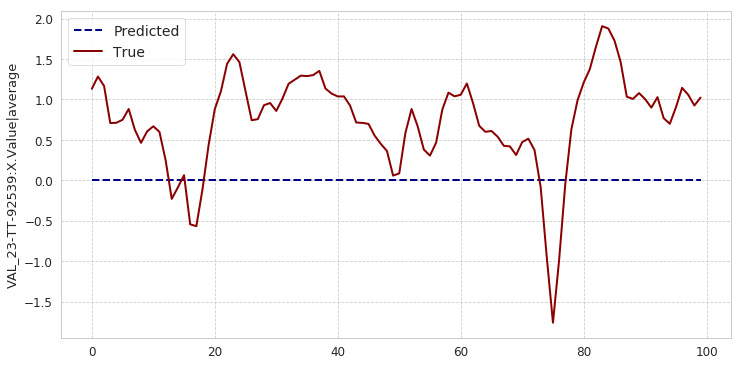

In [43]:
visualise_heuristic(predict_mean)

In [44]:
print("\nPREDICTING MEAN")
val_mean, test_mean = evaluate_heuristic(predict_mean)


PREDICTING MEAN

       Validation data
+----+------------------------------------+----------------------+------------------------+
|    | Tag                                |   MAE (Standardized) |   MAE (Unstandardized) |
|----+------------------------------------+----------------------+------------------------|
|  0 | VAL_23-FT-92537-01:X.Value|average |              0.94544 |            20366.04303 |
|  1 | VAL_23-TT-92539:X.Value|average    |              1.13077 |               11.68060 |
|  2 | VAL_23-PT-92539:X.Value|average    |              0.80240 |                0.64825 |
|  3 | Average                            |              0.95954 |             6792.79062 |
+----+------------------------------------+----------------------+------------------------+

       Testing data
+----+------------------------------------+----------------------+------------------------+
|    | Tag                                |   MAE (Standardized) |   MAE (Unstandardized) |
|----+------------

### Predict the moving average
Predict the previous moving average value

In [45]:
cumsum = np.cumsum(y_valid,axis=0)
ma = np.array([cumsum[n-1]/n for n in range(1,len(cumsum)+1)])

In [46]:
def predict_ma(y_data):
    cumsum = np.cumsum(y_data, axis=0)
    ma = np.array([cumsum[n-1]/n for n in range(1,len(cumsum)+1)])

    preds = ma[:-1]
    targets = y_data[1:]
    return preds, targets

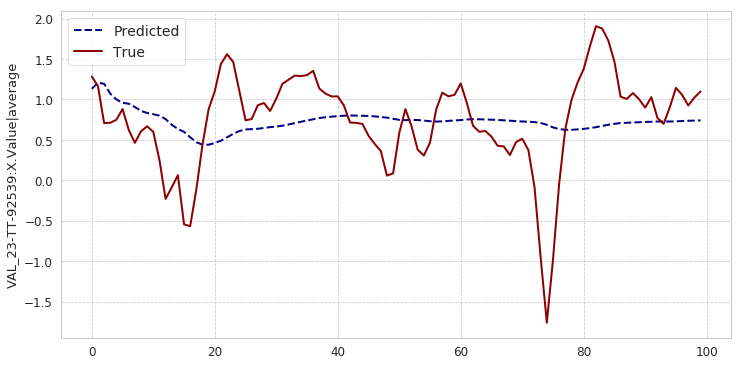

In [47]:
visualise_heuristic(predict_ma)

In [48]:
print("\nPREDICTING MOVING AVERAGE")
val_ma, test_ma = evaluate_heuristic(predict_ma)


PREDICTING MOVING AVERAGE

       Validation data
+----+------------------------------------+----------------------+------------------------+
|    | Tag                                |   MAE (Standardized) |   MAE (Unstandardized) |
|----+------------------------------------+----------------------+------------------------|
|  0 | VAL_23-FT-92537-01:X.Value|average |              0.73329 |            15796.08336 |
|  1 | VAL_23-TT-92539:X.Value|average    |              0.75241 |                7.77220 |
|  2 | VAL_23-PT-92539:X.Value|average    |              0.80249 |                0.64832 |
|  3 | Average                            |              0.76273 |             5268.16796 |
+----+------------------------------------+----------------------+------------------------+

       Testing data
+----+------------------------------------+----------------------+------------------------+
|    | Tag                                |   MAE (Standardized) |   MAE (Unstandardized) |
|----+--

### Summary for the simple heuristics

In [49]:
indexes = ['Prev.', 'Mean', 'MA']
columns = ['FT', 'TT', 'PT', 'Avg']
texpath = ROOT_PATH + "latex-exports/benchmarks/" + "simple_heuristics_error_table.tex"
simple_heuristics_df, tex = get_summary(val_dicts = [val_prev, val_mean, val_ma], 
                                   test_dicts = [test_prev, test_mean, test_ma],
                                   columns=columns, indexes=indexes, unstd=False, texpath=texpath)
print(tex)
simple_heuristics_df.head()

\begin{tabular}{lcccccccc}
\toprule
{} & \multicolumn{4}{c}{Validation} & \multicolumn{4}{c}{Test} \\
{} &         FT &      TT &      PT &     Avg &      FT &      TT &      PT &     Avg \\
\midrule
\textbf{Prev.} &     0.8145 &  0.1645 &  0.5252 &  0.5014 &  0.8633 &  0.1844 &  0.5619 &  0.5365 \\
\textbf{Mean } &     0.9454 &  1.1308 &  0.8024 &  0.9595 &  0.8665 &  1.1623 &  0.8418 &  0.9569 \\
\textbf{MA   } &     0.7333 &  0.7524 &  0.8025 &  0.7627 &  0.8326 &  0.7166 &  0.8409 &  0.7967 \\
\bottomrule
\end{tabular}



Validation                            Test                        
              FT      TT      PT     Avg      FT      TT      PT     Avg
Prev.     0.8145  0.1645  0.5252  0.5014  0.8633  0.1844  0.5619  0.5365
Mean      0.9454  1.1308  0.8024  0.9595  0.8665  1.1623  0.8418  0.9569
MA        0.7333  0.7524  0.8025  0.7627  0.8326  0.7166  0.8409  0.7967

# (3) Simple Linear Models
---
All the models are fit using the `sklearn`-package. Hold-out validation is used wherever relevant to find the optimal parameters of the fit.  

## Define models to evaluate and plot the models

In [50]:
def evaluate_linear_model(model, x_valid=x_valid, y_valid=y_valid, x_test=x_test, y_test=y_test):
    """
    Prints the performance of a model on the validation and testing data. Returns dictionaries of the validation
    and testing error. 
    
    :param model: The fitted model that can use the .predict() function
    :param x_valid: matrix of validation features. Default=x_valid.
    :param y_valid: matrix of validation targets. Default=y_valid.
    :param x_test: matrix of test features. Default=x_test.
    :param y_test: matrix of test targets. Default=y_test. 
    
    :return: dictionaries of validation and test errors as returned from evaluate_error()
    """
    
    print("\n       Validation data")
    preds = model.predict(x_valid)
    targets = y_valid
    val_errs = evaluate_error(preds,targets)
    print(val_errs['err_table'])

    print("\n       Testing data")
    preds = model.predict(x_test)
    targets = y_test
    test_errs = evaluate_error(preds,targets)
    print(test_errs['err_table'])
    
    return val_errs, test_errs

In [51]:
def plot_linear_model(model, x_data=x_valid, y_data=y_valid, start_idx=0, n_obs=200, signal=1, savepath=None):
    """
    Plots a sample of the linear model.
    """
    preds = model.predict(x_data)
    targets = y_data

    signal = 1
    plt.figure()
    plt.plot(preds[start_idx:start_idx+n_obs,signal], color="darkblue", lw=2, label="Predictions")
    plt.plot(targets[start_idx:start_idx+n_obs,signal], color="darkred", lw=2, label="True")
    plt.legend(frameon=True)
    plt.ylabel(target_tags[signal])
    if savepath is not None: 
        plt.savefig(savepath)
    
    plt.show()

## Linear Regression

Linear regression with least squares minimisation.

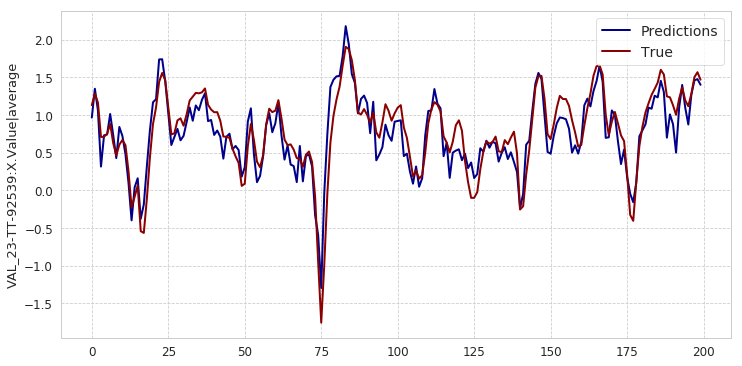

In [52]:
from sklearn.linear_model import LinearRegression
# using the standard settings https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

lm = LinearRegression()
lm.fit(x_train, y_train)
plot_linear_model(lm)

In [53]:
print("\n LINEAR REGRESSION MODEL")
val_linear, test_linear = evaluate_linear_model(lm, x_valid, y_valid, x_test, y_test)


 LINEAR REGRESSION MODEL

       Validation data
+----+------------------------------------+----------------------+------------------------+
|    | Tag                                |   MAE (Standardized) |   MAE (Unstandardized) |
|----+------------------------------------+----------------------+------------------------|
|  0 | VAL_23-FT-92537-01:X.Value|average |              0.68794 |            14819.21871 |
|  1 | VAL_23-TT-92539:X.Value|average    |              0.30318 |                3.13181 |
|  2 | VAL_23-PT-92539:X.Value|average    |              0.96122 |                0.77655 |
|  3 | Average                            |              0.65078 |             4941.04236 |
+----+------------------------------------+----------------------+------------------------+

       Testing data
+----+------------------------------------+----------------------+------------------------+
|    | Tag                                |   MAE (Standardized) |   MAE (Unstandardized) |
|----+---

## Ridge regression
This model solves a regression model where the loss function is the linear least squares function and regularization is given by the l2-norm.

Parameters to optimise with these models is the value of `alpha`. This is found using hold-out-validation. 

Best alpha by validation is: 0.9901


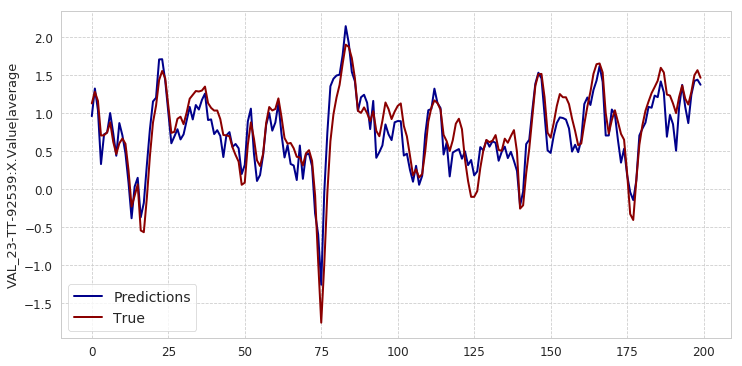

In [54]:
from sklearn.linear_model import Ridge

alphas = np.arange(1E-4,1,0.01)
best_alpha = None
best_err = None
for a in alphas: 
    model = Ridge(alpha = a)
    model.fit(x_train,y_train)
    
    preds = model.predict(x_valid)
    targets = y_valid
    val_err = evaluate_error(preds,targets)['avg_mae']
    if best_err is None or val_err < best_err:
        best_alpha = a
        best_err = val_err

print("Best alpha by validation is:", best_alpha)
    
ridge = Ridge(alpha=best_alpha)
ridge.fit(x_train, y_train)
plot_linear_model(ridge)

In [55]:
print("\n RIDGE REGRESSION MODEL")
val_ridge, test_ridge = evaluate_linear_model(ridge, x_valid, y_valid, x_test, y_test)


 RIDGE REGRESSION MODEL

       Validation data
+----+------------------------------------+----------------------+------------------------+
|    | Tag                                |   MAE (Standardized) |   MAE (Unstandardized) |
|----+------------------------------------+----------------------+------------------------|
|  0 | VAL_23-FT-92537-01:X.Value|average |              0.70706 |            15231.00851 |
|  1 | VAL_23-TT-92539:X.Value|average    |              0.29966 |                3.09543 |
|  2 | VAL_23-PT-92539:X.Value|average    |              0.90780 |                0.73340 |
|  3 | Average                            |              0.63818 |             5078.27911 |
+----+------------------------------------+----------------------+------------------------+

       Testing data
+----+------------------------------------+----------------------+------------------------+
|    | Tag                                |   MAE (Standardized) |   MAE (Unstandardized) |
|----+----

## LASSO
Linear Model trained with L1 prior as regularizer. Technically the Lasso model is optimizing the same objective function as the Elastic Net with l1_ratio=1.0 (no L2 penalty). 

Parameter to optimise with these models is the `alpha` value. This is found using hold-out validation.

Best alpha by validation is: 0.0101


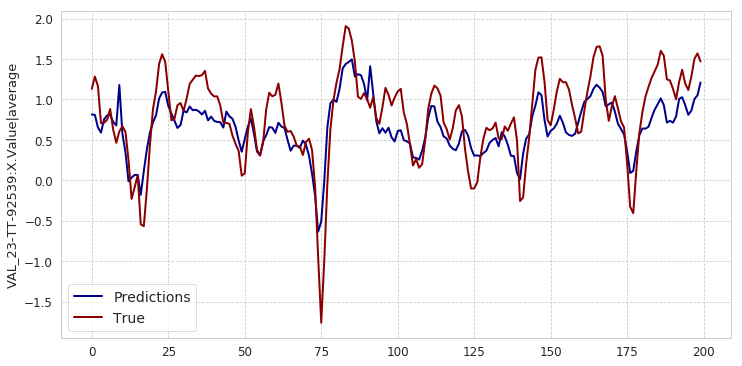

In [56]:
from sklearn.linear_model import Lasso

# using the standard settings https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
# find the optimal value for alpha
alphas = np.arange(1E-4,1,0.01)
best_alpha = None
best_err = None
for a in alphas: 
    model = Lasso(alpha = a)
    model.fit(x_train,y_train)
    
    preds = model.predict(x_valid)
    targets = y_valid
    val_err = evaluate_error(preds,targets)['avg_mae']
    if best_err is None or val_err < best_err:
        best_alpha = a
        best_err = val_err

print("Best alpha by validation is:", best_alpha)
    
lasso = Lasso(alpha=best_alpha)
lasso.fit(x_train, y_train)
plot_linear_model(lasso)

In [57]:
print("\n LASSO REGRESSION MODEL")
val_lasso, test_lasso = evaluate_linear_model(lasso, x_valid, y_valid, x_test, y_test)


 LASSO REGRESSION MODEL

       Validation data
+----+------------------------------------+----------------------+------------------------+
|    | Tag                                |   MAE (Standardized) |   MAE (Unstandardized) |
|----+------------------------------------+----------------------+------------------------|
|  0 | VAL_23-FT-92537-01:X.Value|average |              0.84637 |            18231.96895 |
|  1 | VAL_23-TT-92539:X.Value|average    |              0.31262 |                3.22927 |
|  2 | VAL_23-PT-92539:X.Value|average    |              0.55035 |                0.44462 |
|  3 | Average                            |              0.56978 |             6078.54761 |
+----+------------------------------------+----------------------+------------------------+

       Testing data
+----+------------------------------------+----------------------+------------------------+
|    | Tag                                |   MAE (Standardized) |   MAE (Unstandardized) |
|----+----

## Elastic Nets
Hybrid between Ridge and LASSO. Linear regression with combined L1 and L2 priors as regularizer. 

Parameters to optimise with these models are `alpha` and `l1_ratio`. These are found using an exhaustive grid search and hold-out validation. 

Best parameters are alpha=0.0101, l1_ratio=0.4 giving a validation error of 0.5696618157526433


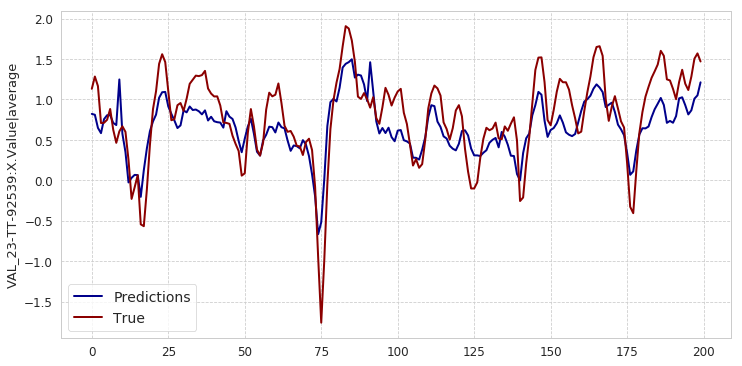

In [58]:
from sklearn.linear_model import ElasticNet

# find optimal value of alpha

alphas = np.arange(1E-4,1,0.01)
#l1s = [.01, .1, .5, .7, .9, .95, .97, .99, 1]
l1s = [.01, .1, .4,.7,.9,.95,.97,.99]
best_params = (alphas[0],l1s[0])
best_err = np.inf
for a in alphas: 
    for l1 in l1s: 
        model = ElasticNet(alpha = a, l1_ratio=l1, max_iter=2000)
        model.fit(x_train,y_train)

        preds = model.predict(x_valid)
        targets = y_valid
        val_err = evaluate_error(preds,targets)['avg_mae']
        if val_err < best_err:
            best_params = (a,l1)
            best_err = val_err
print("Best parameters are alpha={0}, l1_ratio={1} giving a validation error of {2}".format(
        best_params[0], best_params[1], best_err))
        
elnet = ElasticNet(alpha=best_params[0], l1_ratio=best_params[1], max_iter=2000)
elnet.fit(x_train, y_train)
plot_linear_model(elnet)

In [59]:
print("\n ELASTIC NET MODEL")
val_elnet, test_elnet = evaluate_linear_model(elnet, x_valid, y_valid, x_test, y_test)


 ELASTIC NET MODEL

       Validation data
+----+------------------------------------+----------------------+------------------------+
|    | Tag                                |   MAE (Standardized) |   MAE (Unstandardized) |
|----+------------------------------------+----------------------+------------------------|
|  0 | VAL_23-FT-92537-01:X.Value|average |              0.84544 |            18211.85146 |
|  1 | VAL_23-TT-92539:X.Value|average    |              0.31534 |                3.25733 |
|  2 | VAL_23-PT-92539:X.Value|average    |              0.54821 |                0.44289 |
|  3 | Average                            |              0.56966 |             6071.85056 |
+----+------------------------------------+----------------------+------------------------+

       Testing data
+----+------------------------------------+----------------------+------------------------+
|    | Tag                                |   MAE (Standardized) |   MAE (Unstandardized) |
|----+---------

## Summary for the linear models

In [63]:
indexes = ['Linear', 'Ridge', 'LASSO', 'ElNet']
columns = ['FT', 'TT', 'PT', 'Avg']
texpath = ROOT_PATH + "latex-exports/benchmarks/" + "linear_models_error_table.tex"
linear_df, tex = get_summary(val_dicts = [val_linear, val_ridge, val_lasso, val_elnet], 
                                   test_dicts = [test_linear, test_ridge, test_lasso, test_elnet],
                                   columns=columns, indexes=indexes, unstd=False, texpath=texpath)

# sorted 
linear_df = linear_df.sort_values(by=('Test','Avg'))
print(latexify(linear_df))
linear_df

\begin{tabular}{lcccccccc}
\toprule
{} & \multicolumn{4}{c}{Validation} & \multicolumn{4}{c}{Test} \\
{} &         FT &      TT &      PT &     Avg &      FT &      TT &      PT &     Avg \\
\midrule
\textbf{ElNet } &     0.8454 &  0.3153 &  0.5482 &  0.5697 &  0.7936 &  0.3138 &  0.6393 &  0.5823 \\
\textbf{LASSO } &     0.8464 &  0.3126 &  0.5504 &  0.5698 &  0.7957 &  0.3139 &  0.6394 &   0.583 \\
\textbf{Ridge } &     0.7071 &  0.2997 &  0.9078 &  0.6382 &  0.7198 &   0.306 &  0.8826 &  0.6361 \\
\textbf{Linear} &     0.6879 &  0.3032 &  0.9612 &  0.6508 &   0.714 &  0.3006 &  0.9238 &  0.6461 \\
\bottomrule
\end{tabular}



Validation                            Test                        
               FT      TT      PT     Avg      FT      TT      PT     Avg
ElNet      0.8454  0.3153  0.5482  0.5697  0.7936  0.3138  0.6393  0.5823
LASSO      0.8464  0.3126  0.5504  0.5698  0.7957  0.3139  0.6394   0.583
Ridge      0.7071  0.2997  0.9078  0.6382  0.7198   0.306  0.8826  0.6361
Linear     0.6879  0.3032  0.9612  0.6508   0.714  0.3006  0.9238  0.6461

# (4) Simpler Machine Learning models
---

## Function to evaluate the ML models

In [34]:
def evaluate_ml(model, params, ntrees_per_signal, x_train=x_train, y_train=y_train, 
                x_valid=x_valid, y_valid=y_valid, x_test=x_test, y_test=y_test):
    
    dicts = []
    for i in range(2):
        test_features, test_targets = (x_valid, y_valid) if i==0 else (x_test, y_test)
        
        predictions = np.zeros(shape=test_targets.shape)
        # get the MAE for each of the signals
        for signal in range(y_train.shape[-1]):
            ntrees = ntrees_per_signal[signal]
            params['n_estimators'] = ntrees
            model.set_params(**params)

            model.fit(x_train, y_train[:,signal])
            
            preds = model.predict(test_features)
            predictions[:,signal] = preds
        
        errs = evaluate_error(predictions,test_targets)
        print("\n       Validation data") if i==0 else print("\n       Testing data")
        print(errs['err_table'])
        
        dicts.append(evaluate_error(predictions,test_targets))
    
    return dicts

## Random Forest
Ensemble method that averages a lot of trees grown on different samples of the training data, they reduce the variance. Bagging, or _Bootstrap Aggregation_, will bootstrap $B$ samples from the dataset, fit a
tree for every sample and average the outcome. By averaging the outcomes of many trees, Bagging will reduce the sampling variablity. However, if the bagged trees are highly correlated and produce
similar outcomes, the improvement won't be substantial.
This will be the case if the dataset has one or more dominant predictors that most trees consistently will use as a split-predictor.
Random Forest decorrelates the trees by randomly sampling $m$ predictors to be considered every time a tree is to be grown. As with Bagging,
Random Forests are built by bootstrapping $B$ samples from the dataset. For every sample, it will fit a tree, but only $m$ predictors
is used as split candidates for the trees. Notice that Bagging is the same as Random Forests for $m$ = $p$, where $p$ is the total number of predictors in the data.

#### Find the optimal number of trees
Fit a model for an increasing amount of trees, calculate the validation MAE for each number of trees, choosing the best one. 

In [35]:
from sklearn.ensemble import RandomForestRegressor
params_rf = {'n_estimators': 1500, 'max_depth': None, 'min_samples_split': 2, 'max_features':'auto', 
             'criterion':'mse', 'random_state':0, 'n_jobs':-1, 'oob_score':True}

rf = RandomForestRegressor(**params_rf)

def get_oob_per_tree(rf_model, x_train, y_train, ntrees_min=50, ntrees_max=2000, delta=50):
    
    trees_arr = np.arange(ntrees_min,ntrees_max+delta,delta)
    oob_errors = np.zeros(len(trees_arr))
    best_trees = trees_arr[0]
    best_err = np.inf
    
    for i, ntrees in enumerate(trees_arr):
        params_rf['n_estimators'] = ntrees
        rf_model.set_params(**params_rf)
        rf_model.fit(x_train, y_train)
        
        print("ntrees={0}, oob_error={1}".format(ntrees,round(1 - rf_model.oob_score_,5)))
        err = 1 - rf_model.oob_score_
        oob_errors[i] = err
        
        if err < best_err:
            best_err = err
            best_trees = ntrees
        
    return oob_errors, best_trees

ntrees_min = 50
ntrees_max = 1500
delta = 50

oob_errors, best_trees = get_oob_per_tree(rf, x_train, y_train, ntrees_min, ntrees_max, delta)

ntrees=50, oob_error=0.41678
ntrees=100, oob_error=0.40462
ntrees=150, oob_error=0.40103
ntrees=200, oob_error=0.39896
ntrees=250, oob_error=0.39781
ntrees=300, oob_error=0.39702
ntrees=350, oob_error=0.39651
ntrees=400, oob_error=0.39607
ntrees=450, oob_error=0.39563
ntrees=500, oob_error=0.39522
ntrees=550, oob_error=0.39509
ntrees=600, oob_error=0.39516
ntrees=650, oob_error=0.39495
ntrees=700, oob_error=0.39481
ntrees=750, oob_error=0.39481
ntrees=800, oob_error=0.39466
ntrees=850, oob_error=0.39454
ntrees=900, oob_error=0.39449
ntrees=950, oob_error=0.39444
ntrees=1000, oob_error=0.39438
ntrees=1050, oob_error=0.39437
ntrees=1100, oob_error=0.39437
ntrees=1150, oob_error=0.39441
ntrees=1200, oob_error=0.39437
ntrees=1250, oob_error=0.39432
ntrees=1300, oob_error=0.39426
ntrees=1350, oob_error=0.39425
ntrees=1400, oob_error=0.39423
ntrees=1450, oob_error=0.39425
ntrees=1500, oob_error=0.39426


Plot the out of bag error development

1400


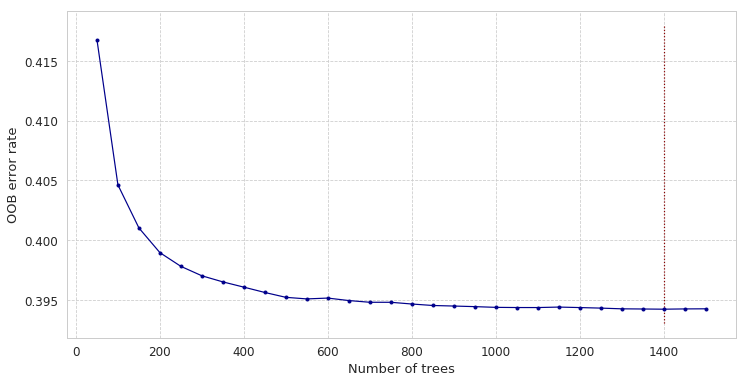

In [36]:
ntrees = best_trees
print(best_trees)
plt.figure()
plt.plot(np.arange(ntrees_min,ntrees_max+delta,delta), oob_errors, marker='o', markersize=3.0, color="darkblue")
plt.vlines(x=ntrees,ymin=plt.ylim()[0],ymax=plt.ylim()[1], linestyle="dotted", color="darkred")
plt.xlabel('Number of trees')
plt.ylabel('OOB error rate')
plt.show()

From the plot, we choose to use set `ntrees` as the one that gives minimum error, visualised by the red line. 

In [37]:
print("\n RANDOM FOREST")
val_rf, test_rf = evaluate_ml(rf, params_rf, ntrees_per_signal=[ntrees,ntrees,ntrees])


 RANDOM FOREST

       Validation data
+----+------------------------------------+----------------------+------------------------+
|    | Tag                                |   MAE (Standardized) |   MAE (Unstandardized) |
|----+------------------------------------+----------------------+------------------------|
|  0 | VAL_23-FT-92537-01:X.Value|average |              0.68108 |            14671.24389 |
|  1 | VAL_23-TT-92539:X.Value|average    |              0.24985 |                2.58090 |
|  2 | VAL_23-PT-92539:X.Value|average    |              0.59473 |                0.48047 |
|  3 | Average                            |              0.50855 |             4891.43509 |
+----+------------------------------------+----------------------+------------------------+

       Testing data
+----+------------------------------------+----------------------+------------------------+
|    | Tag                                |   MAE (Standardized) |   MAE (Unstandardized) |
|----+-------------

## Gradient Boosting Machines
Boosting is another ensemble method that aims to improve stability and predictive accuracy of a single tree by combining many of them.
In Random Forests and Bagging the trees are grown independently of each other. This is not the case for Boosting, however, where the trees
are grown using information from previously grown trees. More specifically, the residuals from the previously grown tree is used as
the response variable when growing the next. The trees will only have a small number of splits each, denoted $d$. This yields a sequence of
$B$ trees, where each tree accounts for some variation i $y$ that was not captured by the previous trees. The boosting method is a slow learner,
and will in general require many trees to get good results. In the end, boosting will often beat methods like Random Forest, although it is comparably
much more computationally expensive.

Gradient Boosting builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage a regression tree is fit on the negative gradient of the given loss function.

Here, we set the number of trees to 10000 and the learning rate to 0.002. Then the validation MAE is calculated for each of the target variables. For each target, the number of trees that give the least validation error is chosen. This is then used to 

In [38]:
from sklearn.ensemble import GradientBoostingRegressor
params_gbm = {'n_estimators': 10000, 'max_depth': 5, 'min_samples_split': 2,
              'learning_rate': 0.002, 'loss': 'lad'}

gbm = GradientBoostingRegressor(**params_gbm)
train_scores = np.zeros(shape=(params_gbm['n_estimators'],y_train.shape[-1]))
valid_scores = np.zeros(shape=(params_gbm['n_estimators'],y_train.shape[-1]))

for output in range(len(target_tags)):
    gbm.fit(x_train, y_train[:,output])
    train_scores[:,output] = gbm.train_score_
    
    for i, y_pred in enumerate(gbm.staged_predict(x_valid)):
        valid_scores[i,output] = gbm.loss_(y_valid[:,output], y_pred)

Plot the training history with the validation scores

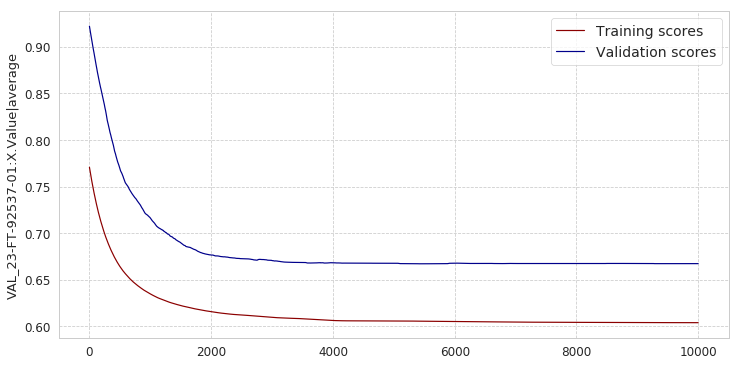

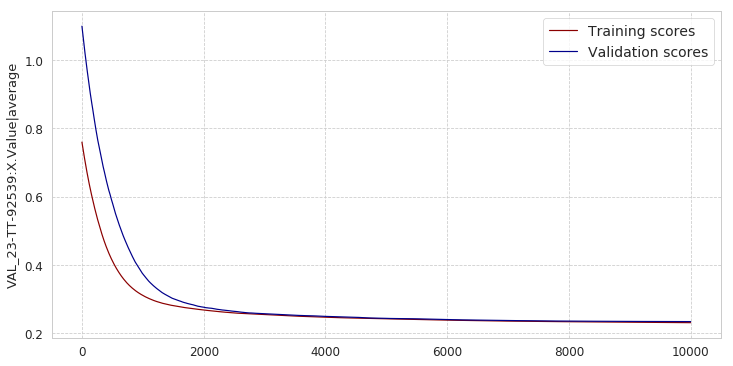

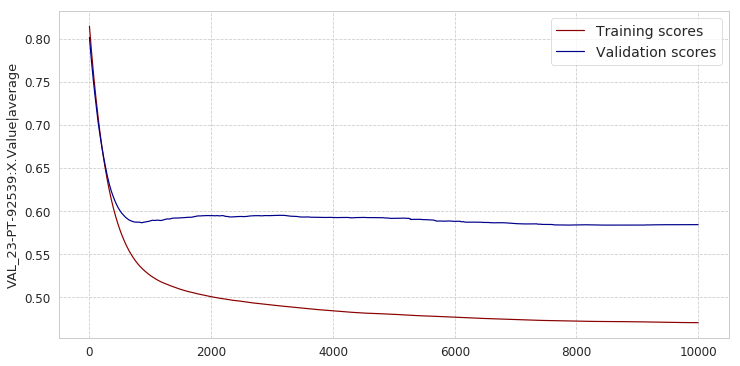

In [39]:
for out in range(train_scores.shape[-1]):
    plt.figure()
    plt.plot(train_scores[:,out], c="darkred", label="Training scores")
    plt.plot(valid_scores[:,out], c="darkblue", label="Validation scores")
    plt.legend(frameon=True)
    plt.ylabel(target_tags[out])
    plt.show()

We see that the best number of trees varies for each tag. Overfitting starts when validation error increases. We therefore choose the number of trees that give the minimum validation error for each of the tags. 

In [40]:
best_trees = [np.where(valid_scores[:,out] == min(valid_scores[:,out])) for out in range(len(target_tags))]
best_trees = [t[0][0] for t in best_trees]
print(best_trees)

[5481, 9995, 8946]


In [41]:
print("\n Gradient Boosting")
val_gbm, test_gbm = evaluate_ml(gbm, params_gbm, best_trees)


 Gradient Boosting

       Validation data
+----+------------------------------------+----------------------+------------------------+
|    | Tag                                |   MAE (Standardized) |   MAE (Unstandardized) |
|----+------------------------------------+----------------------+------------------------|
|  0 | VAL_23-FT-92537-01:X.Value|average |              0.66736 |            14375.70918 |
|  1 | VAL_23-TT-92539:X.Value|average    |              0.23378 |                2.41490 |
|  2 | VAL_23-PT-92539:X.Value|average    |              0.58543 |                0.47296 |
|  3 | Average                            |              0.49552 |             4792.86568 |
+----+------------------------------------+----------------------+------------------------+

       Testing data
+----+------------------------------------+----------------------+------------------------+
|    | Tag                                |   MAE (Standardized) |   MAE (Unstandardized) |
|----+---------

## Summary for the simpler Machine Learning models

In [42]:
indexes = ['RF', 'GBM']
columns = ['FT', 'TT', 'PT', 'Avg']
texpath = ROOT_PATH + "latex-exports/benchmarks/" + "ml_error_table.tex"
ml_df, tex = get_summary(val_dicts = [val_rf, val_gbm], 
                               test_dicts = [test_rf, test_gbm],
                               columns=columns, indexes=indexes, unstd=False, texpath=texpath)
print(tex)
ml_df

\begin{tabular}{lcccccccc}
\toprule
{} & \multicolumn{4}{c}{Validation} & \multicolumn{4}{c}{Test} \\
{} &         FT &     TT &     PT &    Avg &     FT &     TT &     PT &    Avg \\
\midrule
\textbf{RF } &      0.681 &   0.25 &  0.595 &  0.509 &  0.703 &  0.299 &   0.63 &  0.544 \\
\textbf{GBM} &      0.667 &  0.234 &  0.585 &  0.496 &  0.737 &  0.282 &  0.633 &   0.55 \\
\bottomrule
\end{tabular}



Validation                        Test                     
            FT     TT     PT    Avg     FT     TT     PT    Avg
RF       0.681   0.25  0.595  0.509  0.703  0.299   0.63  0.544
GBM      0.667  0.234  0.585  0.496  0.737  0.282  0.633   0.55

# (5) Overall summary
---

A summary of all the benchmarks with their average MAE

In [43]:
dfs = [simple_heuristics_df, linear_df, ml_df]
benchmark_summary_df = pd.concat(dfs,axis=0)

tex = benchmark_summary_df.to_latex(column_format="l" + "c"*(benchmark_summary_df.shape[-1]), bold_rows=True)
print(tex)
benchmark_summary_df

\begin{tabular}{lcc}
\toprule
{} &  Avg. validation MAE &  Avg. testing MAE \\
\midrule
\textbf{Predict previous   } &             0.501427 &          0.536507 \\
\textbf{Random Forest      } &             0.508552 &          0.544161 \\
\textbf{Gradient Boosting  } &             0.495523 &          0.550481 \\
\textbf{ElNet              } &             0.569662 &          0.582256 \\
\textbf{LASSO              } &             0.569781 &          0.582997 \\
\textbf{Ridge regression   } &             0.638175 &          0.636134 \\
\textbf{Linear regression  } &             0.650782 &          0.646130 \\
\textbf{Predict moving avg.} &             0.762732 &          0.796692 \\
\textbf{Predict mean       } &             0.959540 &          0.956863 \\
\bottomrule
\end{tabular}



,Avg. validation MAE,Avg. testing MAE
Predict previous,0.501427,0.536507
Random Forest,0.508552,0.544161
Gradient Boosting,0.495523,0.550481
ElNet,0.569662,0.582256
LASSO,0.569781,0.582997
Ridge regression,0.638175,0.636134
Linear regression,0.650782,0.646130
Predict moving avg.,0.762732,0.796692
Predict mean,0.959540,0.956863


In [ ]:
# print the table with the average error for validation and test set
avg_benchmark_summary_df = benchmark_summary_df[('Validation', 'Avg'), ('Test', 'Avg')]
tex = avg_benchmark_summary_df.to_latex(column_format="l" + "c"*(len(columns)), bold_rows=True)

In [ ]:
val_data = np.array([d['MAE (Standardized)'] for d in val_dicts]).T
test_data = np.array([d['MAE (Standardized)'] for d in test_dicts]).T

benchmark_summary_all_df = pd.DataFrame(np.column_stack([val_data,test_data]), index=indexes,columns=columns)
benchmark_summary_all_df = benchmark_summary_df.sort_values('Avg. testing MAE') # sort by testing error

tex = benchmark_summary_df.to_latex(column_format="l" + "c"*(len(columns)), 
                      bold_rows=True)
print(tex)
benchmark_summary_df

In [44]:
# save dfs
savepath = ROOT_PATH + "models/dataframes/"

simple_heuristics_df.to_pickle(savepath + "simple_heuristics_df.pkl")
linear_df.to_pickle(savepath + "linear_models_df.pkl")
ml_df.to_pickle(savepath + "ml_df.pkl")
benchmark_summary_df.to_pickle(savepath + "benchmarks_summary_df.pkl")
avg_benchmark_summary_df.to_pickle(savepath + "avg_benchmarks_summary_df.pkl")